# 1. Подготовка данных

## 1.1 Предобработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set(style='darkgrid',palette ='bright' ,font_scale=1.5)  # , 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import timeit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
try:    
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [3]:
# Функция для вывода свойств датафрэйма
def df_info(df):
    #display(df.describe())
    display(df.head())
    df.info()
    print()
    print('Кол-во дубликатов = ', df.duplicated().sum())
    print('Кол-во пропусков в строках:')
    display(df.isna().sum())

Для удобства приведем названия столбцов к нижнему регистру

In [4]:
df.columns = [name.lower() for name in df.columns]
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [5]:
df_info(df)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

По предварительной оценке датасета видим:  
- в датасете есть дубликаты 4 шт
- в датасете есть пропуски
- есть ошибки в типаx данных

### 1.1.1 Удаляем дубликаты

In [6]:
df = df.drop_duplicates().reset_index(drop=True)

### 1.1.2 Удаляем ненужные столбцы

В датасете есть признаки, которые не являются техническими или другими значимыми характеристиками и соотвесвенно не влияющие на целевой признак (цену) - эти столбцы можно удалить:
        - DateCrawled — дата скачивания анкеты из базы
        - DateCreated — дата создания анкеты
        - RegistrationMonth - месяц регистрации автомобиля
        - NumberOfPictures — количество фотографий автомобиля
        - PostalCode — почтовый индекс владельца анкеты (пользователя)
        - LastSeen — дата последней активности пользователя

Есть сомнения по поводу не нужности RegistrationMonth. Поэтому посмотрим на зависимость цены от этого признака

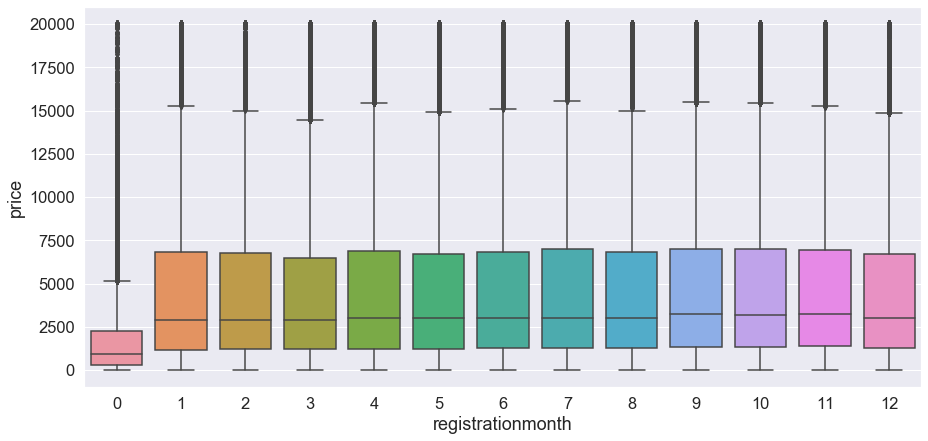

In [7]:
plt.figure(figsize = (15,7))
sns.boxplot(data = df, x = 'registrationmonth' , y = 'price')

Видим что в каждый распределение цены по месяцам практически одинаковое. Видим, что есть значение месяц = 0 - это явная ошибка. Стоит сообщить в источник данных, а в данной задаче мы удаляем данный столбец вместе с остальными не нужными признаками

In [8]:
df.drop(columns = ['datecrawled','datecreated', 
                   'numberofpictures', 'registrationmonth', 'postalcode', 'lastseen'], inplace=True)
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### 1.1.3 Оставшиеся признаки имеют правильный тип данных, замена типа не требуется

### 1.1.4 Анализ оставшихся признаков на предмет аномалий

#### 1.1.4.1 Признак  power
Строим гистограмму

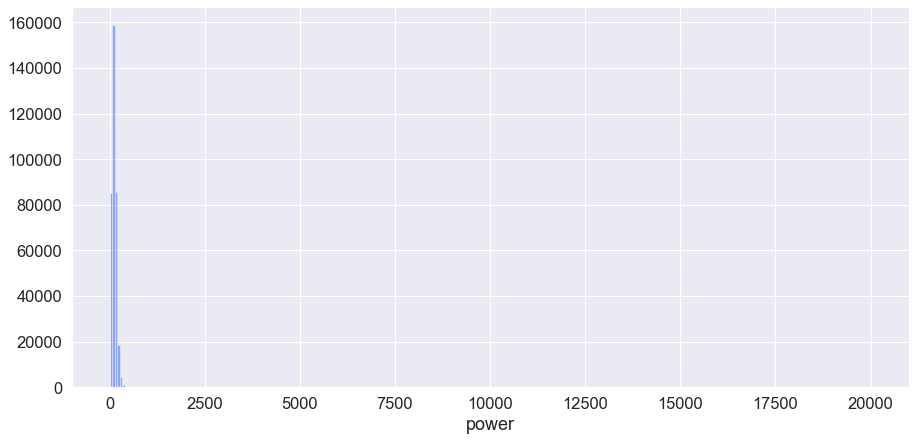

In [9]:
plt.figure(figsize = (15,7))
sns.distplot(df.power, kde= False, bins=300)

Видим на гистограмме выбросы. Выведем строки с аномальными значениями

In [10]:
df[(df['power'] > 500)]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
3746,0,NaN,2017,manual,750,NaN,150000,petrol,smart,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
348964,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351943,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353489,12500,NaN,2017,manual,2000,other,60000,gasoline,chrysler,no
353629,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


Трудно сказать, являются ли значения power ошибочными, или же это реальные характеристики АВТО.  
Но возьмем срез по конкретной марке и модели авто и построим по нему отдельную гистограмму:

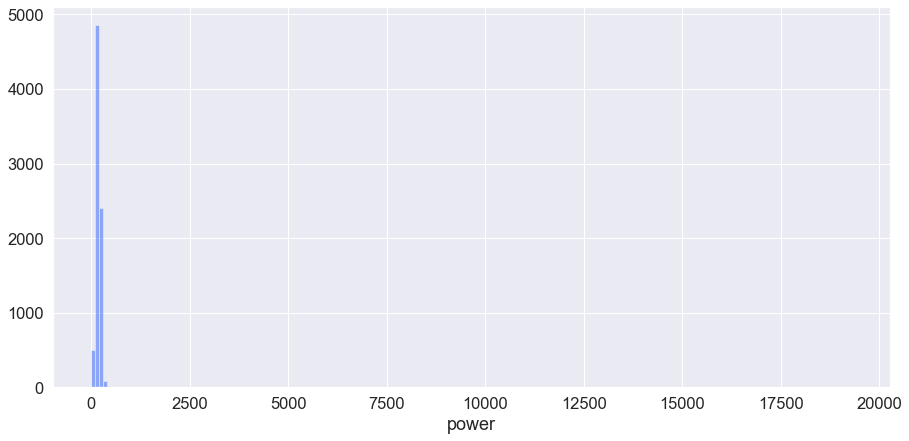

In [11]:
plt.figure(figsize = (15,7))
sns.distplot(df[(df['brand'] == 'bmw') & (df['model'] == '5er')].power, kde= False, bins=200)

Видим, что для конкретной модели авто есть силные выбросы - это явная ошибка. Скорее всего величина задана в других единицах измерения. Стоит сообщить об этом в источник данных.  
Посмотрим на 99% квантиль признака power: 

In [12]:
df.power.quantile(0.99)

300.0

99% - квантиль выдал не слишком большую величину. Некоторые авто могут иметь такое значение.  Лучше выберем порог на глаз по общей гистограмме - 1000.  И удалим все строки, превышающие это значение  

In [13]:
df[df['power'] > 1000].shape[0]

302

Всего лишь 302 строки

In [14]:
df = df[~(df['power'] > 1000)].reset_index(drop=True)
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354058,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354059,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354060,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354061,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Также посмотрим на строки с нулевой мощностью:

In [15]:
df[(df['power'] == 0)]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354032,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354040,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354057,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354058,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Более 10% датасета имеют ошибочно указанную нулевую мощность. Если удалить данные строки, то потеряем много ценной информации в других признаках.  Эту величину можно довольно точно восстановить по имеющимся в таблице признакам вручную. В данной задаче не будем делать ручное заполнение. Принимаем решение заполнить нули медианным значением.

In [16]:
power_median = df.power.median()
df['power'].replace(0, power_median, inplace=True)
#Проверка
df[df['power'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired


#### 1.1.4.2 Признак  registrationyear
Строим гистограмму

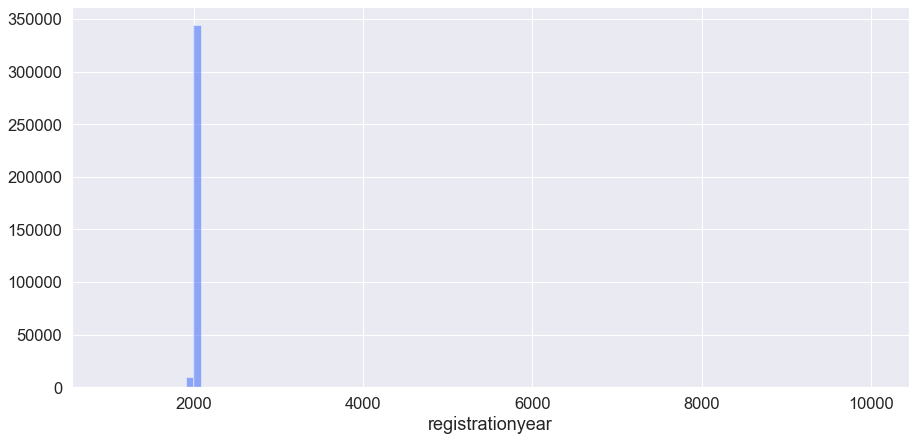

In [17]:
plt.figure(figsize = (15,7))
sns.distplot(df.registrationyear, kde = False, bins=100)

Видим явные ошибки в указании даты.  Ограничим допустимые значения 1908...2020 годами и удалим все аномальные значения

In [18]:
df[~(df['registrationyear'] >= 1908) | ~(df['registrationyear'] <=2020)]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
622,0,NaN,1111,NaN,105,NaN,5000,NaN,opel,NaN
12938,49,NaN,5000,NaN,105,golf,5000,NaN,volkswagen,NaN
15139,0,NaN,9999,NaN,105,NaN,10000,NaN,sonstige_autos,NaN
15862,1700,NaN,3200,NaN,105,NaN,5000,NaN,sonstige_autos,NaN
16054,190,NaN,1000,NaN,105,mondeo,5000,NaN,ford,NaN
...,...,...,...,...,...,...,...,...,...,...
335443,0,NaN,7500,manual,105,other,10000,petrol,mini,no
340260,0,NaN,3500,manual,75,NaN,5000,petrol,sonstige_autos,NaN
341499,1,NaN,3000,NaN,105,zafira,5000,NaN,opel,NaN
348529,1,NaN,1000,NaN,1000,NaN,150000,NaN,sonstige_autos,NaN


164 аномальных значений. Удаляем их

In [19]:
df = df[(df['registrationyear'] >= 1908) & (df['registrationyear'] <=2020)].reset_index(drop=True)
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,105,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
353894,0,NaN,2005,manual,105,colt,150000,petrol,mitsubishi,yes
353895,2200,NaN,2005,NaN,105,NaN,20000,NaN,sonstige_autos,NaN
353896,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
353897,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### 1.1.4.2 Признак  kilometer
Строим гистограмму

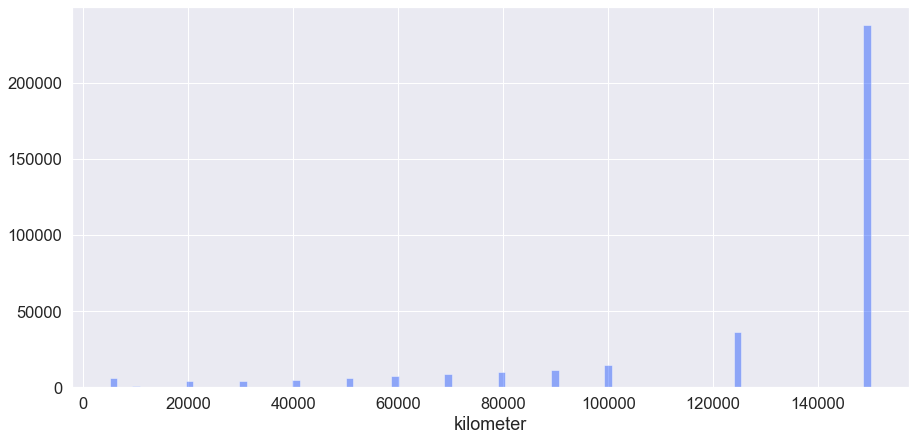

In [20]:
plt.figure(figsize = (15,7))
sns.distplot(df.kilometer, kde = False, bins=100)

Тут аномальных значений не обнаружено. 

### 1.1.5 Заполнение пропусков 

Проверим, сколько данных мы потеряем при удалении пропусков

In [21]:
(df.shape[0] - df.dropna().shape[0]) / df.shape[0] * 100

30.57821581863752

Теряем 30% данных. Это очень много. Попробуем заполнить пропуски.
Получим список признаков, в которых есть пропуски и рассмотрим поочередно каждый из них

In [22]:
feat_with_nan = list(df.isna().sum()[df.isna().sum() != 0].index)
feat_with_nan

['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']

Имеются пропуски только в категориальных  признаках. Предварительный иследовательский анализ не выявил зависимости, по которым можно восстановить пропуски. Для наглядности изобразим зависимость между признаками:

#### 1.1.5.1 Столбец vehicletype - тип кузова

Пропуски в этом столбце можем восстановить по информации в столбцах 'model','brand'. (для 100% точности можно также учесть 'registrationyear' - но это будет слишком глубокий анализ, в данном проекте не будем учитывать)  
Посмотрим на количество таких строк

In [23]:
df[df['vehicletype'].isna() &
   ~df['model'].isna() & ~df['brand'].isna() ][['vehicletype','model','brand']]

,vehicletype,model,brand
0,NaN,golf,volkswagen
16,NaN,polo,volkswagen
22,NaN,meriva,opel
26,NaN,c4,citroen
31,NaN,clio,renault
...,...,...,...
353835,NaN,polo,volkswagen
353866,NaN,outlander,mitsubishi
353876,NaN,c_klasse,mercedes_benz
353891,NaN,159,alfa_romeo


Есть потенциальная возможность заполнить очень большое число пропусков vehicletype.  
Для этого, как вариант, можно в интернете найти сайт с тех. информацией для разных автомобилей и сделать парсинг.  
В данном проекте мы не будем производить парсинг, а заполним лишь несколько значений по информации, взятой из интернете вручную, чтобы показать алгоритм

Создадим таблицу всех возможных комбинаций 'brand', 'model', по которым можем восстановить 'vehicletype'

In [24]:
df_brand_model = df[
    df['vehicletype'].isna() & ~df['model'].isna() & ~df['brand'].isna()][['brand', 'model', 'vehicletype']].drop_duplicates()
df_brand_model.sort_values('brand', inplace=True, ignore_index=True)
df_brand_model

,brand,model,vehicletype
0,alfa_romeo,147,NaN
1,alfa_romeo,159,NaN
2,alfa_romeo,spider,NaN
3,alfa_romeo,145,NaN
4,alfa_romeo,156,NaN
...,...,...,...
278,volvo,v60,NaN
279,volvo,s60,NaN
280,volvo,other,NaN
281,volvo,v50,NaN


Заполняем пропуски  vehicletype в данной таблице частично - в ручную найденными в интернете данными (в идеале можно сделать парсинг и заполнить  все пропуски).  
P.S.
При оценке варианта с парсингом установлено:
- в данном датасете есть не все возможные типы 'vehicletype', например отсутсвует очень популярный hutchbak. Стоит обсудить это с источником данных  
- для некоторых комбинаций brand и model возможны разные варианты 'vehicletype'.    
Поэтому в процессе заполнения пропусков необходимо консультироваться со специалистами по продукту (по автомобилям)

In [25]:
# Ручное заполнение
df_brand_model.loc[(df_brand_model['brand'] == 'lada') 
        & (df_brand_model['model'].isin(['niva'])),'vehicletype'] = 'suv'

df_brand_model.loc[(df_brand_model['brand'] == 'bmw') 
        & (df_brand_model['model'].isin(['5er','7er'])),'vehicletype'] = 'sedan'

df_brand_model.loc[(df_brand_model['brand'] == 'toyota') 
        & (df_brand_model['model'].isin(['rav'])),'vehicletype'] = 'suv'

df_brand_model.loc[(df_brand_model['brand'] == 'toyota') 
        & (df_brand_model['model'].isin(['corolla', 'avensis'])),'vehicletype'] = 'sedan'

Выделим в отбельную таблицу найденные значения

In [26]:
df_brand_model_filled = df_brand_model.dropna()
df_brand_model_filled.reset_index(drop=True, inplace=True)
df_brand_model_filled

,brand,model,vehicletype
0,bmw,7er,sedan
1,bmw,5er,sedan
2,lada,niva,suv
3,toyota,rav,suv
4,toyota,corolla,sedan
5,toyota,avensis,sedan


Восстановили вручную 6 "вариантов" пропуска vehicletype.  
Теперь занесем эти значения в наш исходный датасет.  
Используем для этого метод merge

In [27]:
df = df.merge(df_brand_model_filled, how='left', on = ['brand','model'])
df

,price,vehicletype_x,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,vehicletype_y
0,480,NaN,1993,manual,105,golf,150000,petrol,volkswagen,NaN,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,NaN
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,NaN
...,...,...,...,...,...,...,...,...,...,...,...
353894,0,NaN,2005,manual,105,colt,150000,petrol,mitsubishi,yes,NaN
353895,2200,NaN,2005,NaN,105,NaN,20000,NaN,sonstige_autos,NaN,NaN
353896,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,NaN
353897,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,NaN


Теперь у нас есть:
- столбец vehicletype_x - там исходные значения датасета;
- столбец vehicletype_y - там найденные нами значения, взятые из датасета df_brand_model_filled + все остальные значения заполненные NaN-ами.  
  
Можем посмотреть - сколько в принципе пропусков мы заполним: 

In [28]:
df.loc[df['vehicletype_x'].isna() & ~df['vehicletype_y'].isna()]

,price,vehicletype_x,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,vehicletype_y
71,2300,NaN,1997,manual,150,5er,150000,NaN,bmw,no,sedan
1527,2200,NaN,2016,auto,105,5er,150000,petrol,bmw,no,sedan
2403,13500,NaN,2006,auto,396,5er,150000,NaN,bmw,NaN,sedan
3271,12,NaN,2015,NaN,105,5er,5000,NaN,bmw,NaN,sedan
3810,3800,NaN,2016,manual,110,avensis,150000,petrol,toyota,no,sedan
...,...,...,...,...,...,...,...,...,...,...,...
350739,3450,NaN,2017,auto,193,5er,150000,lpg,bmw,yes,sedan
351573,7000,NaN,2003,manual,170,5er,150000,petrol,bmw,no,sedan
352520,1290,NaN,2017,auto,170,5er,125000,petrol,bmw,no,sedan
352747,1200,NaN,2016,manual,140,5er,150000,petrol,bmw,no,sedan


Благодаря 6 полученным вручную значениям vehicletype мы смогли заполнить 535 пропусков - неплохой результат.  
Производим заполнение:

In [29]:
df.loc[
    df['vehicletype_x'].isna() & ~df['vehicletype_y'].isna(), 'vehicletype_x'] = df.loc[
    df['vehicletype_x'].isna() & ~df['vehicletype_y'].isna(), 'vehicletype_y']

In [30]:
# Проверяем, что заполнение прошло успешно
df.loc[df['vehicletype_x'].isna() & ~df['vehicletype_y'].isna()]

,price,vehicletype_x,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,vehicletype_y


Теперь удаляем ненужный столбец vehicletype_y и переименовываем vehicletype_x обратно в vehicletype

In [31]:
df.rename(columns = {'vehicletype_x':'vehicletype'}, inplace=True)
df.drop(columns = 'vehicletype_y', inplace=True)
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,105,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
353894,0,NaN,2005,manual,105,colt,150000,petrol,mitsubishi,yes
353895,2200,NaN,2005,NaN,105,NaN,20000,NaN,sonstige_autos,NaN
353896,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
353897,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


На данном этапе заканчиваем обработку пропусков в столбце vehicletype.  Мы показали, как их заполнять. Полное заполнение можно сделать с помощью парсинга. Оставшиеся пропуски обработаем отдельно с следующих пунктах

#### 1.1.5.2 По оставшимся пропускам в столбцах 'gearbox', 'model', 'fueltype', 'notrepaired' нет информации как их заполнять.   Вместо их удаления и потери 30% данных закодируем пропуски в отдельные категории и попробуем обучить наши модели на таких данных. См. п. 1.4

## 1.2 Отделение целевого признака от остальных признаков

In [32]:
X = df.drop(columns = 'price')
y = df.price
# Удаляем не нужные далее данные
del df

### Дальше будет следующая последовательность:  
1.3 Обработка категориальных признаков, потому что у нас есть категориальный признак model с несколькими сотнями значений. Если сначала сделать разделение на обучающую и тестовую выборки то есть риск что не все варианты model попадут в каждую из выборок.  
1.4 Разделение на обучающую и тестовую выборки.  
1.5 Нормализация числовых признаках - тут уже нужно отдельно обрабатывать обучающую и тестовую выборки

## 1.3 Преобразование категориальных признаков.
Одна часть моделей работает с one-hot преобразованными данными.  
Модель LGBM работает с OrdinalEncoding - преобразованными данными.   
Для модели Catboost также будем использовать уже OrdinalEncoding-преобразованные данные, т.к. в них уже будут предобработаны пропуски NaN, которые catboost не принимает.    

Выделим категориальные признаки

In [33]:
cat_features = X.columns[X.dtypes == 'object']
cat_features

Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'], dtype='object')

### 1.3.1  One-hot преобразованные данные:

In [34]:
X_onehot = pd.get_dummies(X, drop_first=True, dummy_na=True)
X_onehot

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,brand_nan,notrepaired_yes,notrepaired_nan
0,1993,105,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353894,2005,105,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
353895,2005,105,20000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
353896,2000,101,125000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353897,1996,102,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### 1.3.2 OrdinalEncoder - преобразованные данные:

In [35]:
X_ordinal = X.copy()
X_ordinal

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,NaN,1993,manual,105,golf,150000,petrol,volkswagen,NaN
1,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
353894,NaN,2005,manual,105,colt,150000,petrol,mitsubishi,yes
353895,NaN,2005,NaN,105,NaN,20000,NaN,sonstige_autos,NaN
353896,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
353897,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Чтобы OrdinalEncoder обработал пропуски - преобразуем в их в произвольный тип данных (выбрали строковую переменную - 'nan_value')

In [36]:
X_ordinal[cat_features] = X[cat_features].fillna("nan_value")
X_ordinal

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,nan_value,1993,manual,105,golf,150000,petrol,volkswagen,nan_value
1,coupe,2011,manual,190,nan_value,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,nan_value
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
353894,nan_value,2005,manual,105,colt,150000,petrol,mitsubishi,yes
353895,nan_value,2005,nan_value,105,nan_value,20000,nan_value,sonstige_autos,nan_value
353896,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
353897,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Делаем OrdinalEncoder - преобразование

In [37]:
X_ordinal[cat_features] = pd.DataFrame(OrdinalEncoder().fit_transform(X_ordinal[cat_features]), columns = cat_features)
X_ordinal

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,3.0,1993,1.0,105,116.0,150000,7.0,38.0,0.0
1,2.0,2011,1.0,190,159.0,125000,2.0,1.0,2.0
2,7.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
3,6.0,2001,1.0,75,116.0,150000,7.0,38.0,1.0
4,6.0,2008,1.0,69,101.0,90000,2.0,31.0,1.0
...,...,...,...,...,...,...,...,...,...
353894,3.0,2005,1.0,105,78.0,150000,7.0,22.0,2.0
353895,3.0,2005,2.0,105,159.0,20000,5.0,33.0,0.0
353896,1.0,2000,0.0,101,106.0,125000,7.0,32.0,1.0
353897,0.0,1996,1.0,102,225.0,150000,2.0,38.0,1.0


Ordinalencoder преобразовал наши данные во float. Модель Catboost в качестве категориальных признаков принимает типы данных string и int.  Поэтому сразу преобразуем float в int

In [38]:
X_ordinal[cat_features] = X_ordinal[cat_features].astype(int)
X_ordinal

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,3,1993,1,105,116,150000,7,38,0
1,2,2011,1,190,159,125000,2,1,2
2,7,2004,0,163,117,125000,2,14,0
3,6,2001,1,75,116,150000,7,38,1
4,6,2008,1,69,101,90000,2,31,1
...,...,...,...,...,...,...,...,...,...
353894,3,2005,1,105,78,150000,7,22,2
353895,3,2005,2,105,159,20000,5,33,0
353896,1,2000,0,101,106,125000,7,32,1
353897,0,1996,1,102,225,150000,2,38,1


## 1.4 Разделяем выборку на обучающую и тестовую

In [39]:
X_onehot_train, X_onehot_test, X_ordinal_train, X_ordinal_test, y_train, y_test = train_test_split(
    X_onehot, X_ordinal, y, test_size=0.2, random_state=42)

# Удаляем не нужные далее данные
del X_onehot, X_ordinal

## 1.5 Нормализация числовых признаков

Выделим числовые признаки

In [40]:
num_features = X.columns[X.dtypes != 'object']
num_features

Index(['registrationyear', 'power', 'kilometer'], dtype='object')

Производим нормирование. Обучаемся на только на обучающей выборке, а преобразование делаем и для обучающей и для тестовой.   Можем взять для обучения как onehot так и ordinal - данные , т.к. в них одни и те же количественные признаки 

In [41]:
scaler = StandardScaler()

scaler.fit(X_onehot_train[num_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [42]:
X_scaled_onehot_train = X_onehot_train.copy()
X_scaled_ordinal_train = X_ordinal_train.copy()

X_scaled_onehot_test = X_onehot_test.copy()
X_scaled_ordinal_test = X_ordinal_test.copy()

In [43]:
X_scaled_onehot_train[num_features] = scaler.transform(X_onehot_train[num_features])
X_scaled_ordinal_train[num_features] = scaler.transform(X_ordinal_train[num_features])

X_scaled_onehot_test[num_features] = scaler.transform(X_onehot_test[num_features])
X_scaled_ordinal_test[num_features] = scaler.transform(X_ordinal_test[num_features])

In [44]:
display(X_scaled_onehot_train.head(2))
display(X_scaled_onehot_test.head(2))

display(X_scaled_ordinal_train.head(2))
display(X_scaled_ordinal_test.head(2))

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,brand_nan,notrepaired_yes,notrepaired_nan
299359,0.653126,-0.549551,-0.086697,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
46159,-4.399423,-0.453250,-2.600380,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,brand_nan,notrepaired_yes,notrepaired_nan
185948,0.254241,1.260912,0.574799,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
262422,-0.543530,-0.337688,0.574799,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
299359,6,0.653126,1,-0.549551,83,-0.086697,7,24,1
46159,1,-4.399423,1,-0.453250,159,-2.600380,7,33,1


,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
185948,8,0.254241,1,1.260912,29,0.574799,2,1,1
262422,5,-0.543530,1,-0.337688,42,0.574799,7,24,1


In [45]:
# Удаляем не нужные далее данные
del X_onehot_train, X_ordinal_train, X_onehot_test, X_ordinal_test

# 2. Обучение моделей  
#### Замечания
1. При обучении моделей будем использовать метод GridSearchCV, который уже включает кроссвалидацию.
2. В качестве метрики используем RMSE
3. Для сокращения скорости вычислений будем для всех моделей задавать n_estimators=5 / iterations = 5.   В конце проекта приводятся результаты расчета для n_estimators / iterations = 30, 100  

Зададим целевую функцию RMSE

In [46]:
def RMSE(y_actual, y_predict):
    return np.sqrt(MSE(y_actual, y_predict))

Также позаботимся о том, чтобы можно было использовать RMSE в качестве метрики при обучении моделей:

In [47]:
my_scorer = make_scorer(RMSE, greater_is_better=False)

Зададим функции обучения и предсказания моделей

In [48]:
# Функция для обучения модели c помощью GridSearchCV и вычисления нужных величин

def model_train(X, y, model):
  # Время начала обучения
  start_time = timeit.default_timer()

  # Обучаем модель
  model.fit(X, y)

  # лучшая модель
  model_best =  model.best_estimator_

  # лучшие гиперпараметры
  model_best_params =  model.best_params_

  # Вычисляем лучшую метрику на кроссвалидации
  RMSE_train = abs(model.best_score_)

  # Вычисляем время обучения
  fit_time = round(timeit.default_timer() - start_time, 1)

  # Выводим вычисленные величины
  print('Лучшие гиперпараметры:')
  print(model_best_params)
  print('Метрика RMSE на обучении: {}'.format(round(RMSE_train,2)))
  print('Время обучения: {:.2} сек'.format(fit_time)) 
  print()

  # возвращаем обученную модель с лучшими ГП,
  # лучшие ГП, метрику, время обучения
  return model.best_estimator_ , model.best_params_, RMSE_train, fit_time

In [49]:
# Функция для расчета метрики на тестовой выборке 
def model_test(X, y, model_fitted):
  # Время начала расчета
  start_time = timeit.default_timer()
  
  # Считаем метрику на тестовой выборке
  RMSE_test = RMSE(y, model_fitted.predict(X))

  # Считаем время предсказания 
  predict_time = round(timeit.default_timer() - start_time, 3)

  # Выводим вычисленные величины
  print('Метрика RMSE на тестовой выборке: {}'.format(round(RMSE_test,2)))
  print('Время предсказания: {} сек'.format(predict_time))

  # Возвращаем метрику на тестовой выборке и время предсказания
  return RMSE_test, predict_time

## 2.1 Константная модель. 

Проверим качество константной модели, чтобы можно было оценить адекватность наших будущих моделей.  
Для начала посмотрим на гистограмму целевого признака

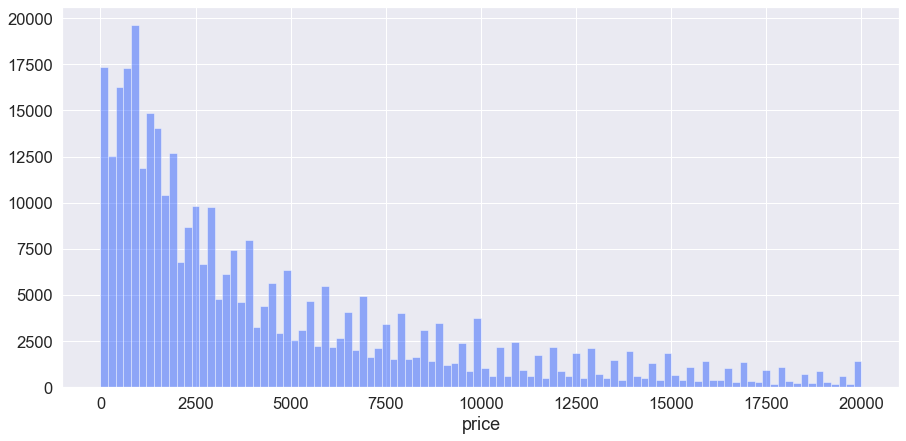

In [50]:
plt.figure(figsize = (15,7))
sns.distplot(y, bins=100, kde=False)

Гистограмма напоминает распределение Пуассона.  Кажется, что выбросов нет. В таком случае лучшую точность должна дать константная модель со средним значением, чем с медианой. На всякий случай проверим и медиану и среднее значение и выберем модель с максимальной точностью

In [51]:
y_median = y_train.median()
y_mean = y_train.mean()

In [52]:
y_median_series = pd.Series([y_median for i in range(len(y_test))])
y_mean_series = pd.Series([y_mean for i in range(len(y_test))])

In [53]:
RMSE_const_model_train = RMSE(y_test, y_median_series)
RMSE_const_model_train

4847.009040324543

In [54]:
RMSE(y_test, y_mean_series)

4525.938329766491

Как и предполагали, константная модель со средним значением дала более высокую точность, чем с медианой. Принимаем для дальнейшего анализа модель со средним значением

In [55]:
RMSE_const_model_test = min([RMSE(y_test, y_median_series),RMSE(y_test, y_mean_series)]) 
RMSE_const_model_test

4525.938329766491

## 2.2 Модель линейная регрессия 

In [56]:
# Задаем гиперпараметры
param_grid_22 = {'n_jobs': [-1]}

# Задаем модель
model_LR = GridSearchCV(estimator = LinearRegression(),
                       param_grid= param_grid_22, cv=3, n_jobs=-1 , scoring = my_scorer)

# Обучаем модель
model_best_LR, model_params_LR, fit_RMSE_LR, fit_time_LR = model_train(X_scaled_onehot_train, y_train, model_LR)

# Считаем метрику на тестовой выборке
predict_RMSE_LR, predict_time_LR =  model_test(X_scaled_onehot_test, y_test, model_best_LR)

Лучшие гиперпараметры:
{'n_jobs': -1}
Метрика RMSE на обучении: 2752.21
Время обучения: 2.1e+01 сек

Метрика RMSE на тестовой выборке: 2778.99
Время предсказания: 0.16 сек


## 2.3 Модель случайный лес

### 2.3.1 случайный лес + onehot

In [57]:
# Задаем гиперпараметры
param_grid_231 = {'n_estimators': [5, 20, 30],
                'max_depth': [20, 30, 40],
                'min_samples_split' : [3, 7, 10],
                 'min_samples_leaf': [2, 4, 6]}
# Сразу подставляем уже найденные лучшие параметры:
param_grid_231 = {'n_estimators': [30],
                'max_depth': [10],
                'min_samples_split' : [3],
                 'min_samples_leaf': [2]}

# Задаем модель
model_RF_onehot = GridSearchCV(estimator = RandomForestRegressor(n_jobs=-1, random_state=42), 
            param_grid= param_grid_231, scoring = my_scorer, cv=3, verbose=1, n_jobs= -1)

# Обучаем модель
model_best_RF_onehot, model_params_RF_onehot, fit_RMSE_RF_onehot, fit_time_RF_onehot = model_train(X_scaled_onehot_train, y_train, model_RF_onehot)

# Считаем метрику на тестовой выборке
predict_RMSE_RF_onehot, predict_time_RF_onehot =  model_test(X_scaled_onehot_test, y_test, model_best_RF_onehot)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Лучшие гиперпараметры:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 30}
Метрика RMSE на обучении: 2044.33
Время обучения: 2.3e+02 сек

Метрика RMSE на тестовой выборке: 2073.67
Время предсказания: 0.292 сек


### 2.3.2 случайный лес + ordinal

In [58]:
# Задаем гиперпараметры
param_grid_232 = {'n_estimators': [5, 20, 30],
                'max_depth': [20, 30, 40],
                'min_samples_split' : [3, 7, 10],
                 'min_samples_leaf': [2, 4, 6]}
# Сразу подставляем уже найденные лучшие параметры:
param_grid_232 = {'n_estimators': [30],
                'max_depth': [30],
                'min_samples_split' : [10],
                 'min_samples_leaf': [2]}

# Задаем модель
model_RF_ordinal = GridSearchCV(estimator = RandomForestRegressor(n_jobs=-1, random_state=42), 
            param_grid= param_grid_232, scoring = my_scorer, cv=3, verbose=1, n_jobs= -1)

# Обучаем модель
model_best_RF_ordinal, model_params_RF_ordinal, fit_RMSE_RF_ordinal, fit_time_RF_ordinal = model_train(X_scaled_ordinal_train, y_train, model_RF_ordinal)

# Считаем метрику на тестовой выборке
predict_RMSE_RF_ordinal, predict_time_RF_ordinal =  model_test(X_scaled_ordinal_test, y_test, model_best_RF_ordinal)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.3s finished


Лучшие гиперпараметры:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 30}
Метрика RMSE на обучении: 1776.97
Время обучения: 3.6e+01 сек

Метрика RMSE на тестовой выборке: 1758.03
Время предсказания: 0.353 сек


## 2.4 Модель XGboost

### 2.4.1 XGboost + onehot

In [59]:
# Задаем гиперпараметры
param_grid_241 = {'booster': ['gbtree'],
                 'max_depth': [14, 17, 20],
                 'min_samples_split': [2, 3],
                 'n_estimators': [10, 30]}

# Сразу подставляем уже найденные лучшие параметры:
param_grid_241 = {'booster': ['gbtree'],
                 'max_depth': [17],
                 'min_samples_split': [2],
                 'n_estimators': [30]}

# Задаем модель
model_XGB_onehot = GridSearchCV(estimator = XGBRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_241, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_XGB_onehot, model_params_XGB_onehot, fit_RMSE_XGB_onehot, fit_time_XGB_onehot = model_train(X_scaled_onehot_train, y_train, model_XGB_onehot)

# Считаем метрику на тестовой выборке
predict_RMSE_XGB_onehot, predict_time_XGB_onehot =  model_test(X_scaled_onehot_test, y_test, model_best_XGB_onehot)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.4min finished


[22:43:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Лучшие гиперпараметры:
{'booster': 'gbtree', 'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 30}
Метрика RMSE на обучении: 1766.48
Время обучения: 3.8e+02 сек

Метрика RMSE на тестовой выборке: 1730.17
Время предсказания: 1.156 сек


### 2.4.2 XGboost + ordinal

In [60]:
# Задаем гиперпараметры
param_grid_242 = {'booster': ['gbtree'],
                 'max_depth': [14, 17, 20, 25],
                 'min_samples_split': [2, 3, 4],
                 'n_estimators': [10, 30]}

# Сразу подставляем уже найденные лучшие параметры:
param_grid_242 = {'booster': ['gbtree'],
                 'max_depth': [14],
                 'min_samples_split': [2],
                 'n_estimators': [30]}

# Задаем модель
model_XGB_ordinal = GridSearchCV(estimator = XGBRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_242, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_XGB_ordinal, model_params_XGB_ordinal, fit_RMSE_XGB_ordinal, fit_time_XGB_ordinal = model_train(X_scaled_ordinal_train, y_train, model_XGB_ordinal)

# Считаем метрику на тестовой выборке
predict_RMSE_XGB_ordinal, predict_time_XGB_ordinal =  model_test(X_scaled_ordinal_test, y_test, model_best_XGB_ordinal)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.0s finished


[22:45:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Лучшие гиперпараметры:
{'booster': 'gbtree', 'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 30}
Метрика RMSE на обучении: 1773.59
Время обучения: 2.6e+01 сек

Метрика RMSE на тестовой выборке: 1738.34
Время предсказания: 0.179 сек


## 2.5 Модель LightGBM

### 2.5.1 Модель LightGBM / n_estimators = 10

In [61]:
# Задаем гиперпараметры
param_grid_251 = {'num_leaves': [1000, 2000, 3000],
                'max_depth': [14, 17, 20, 25],
                'n_estimators' : [5, 10, 30],
                 'min_data_in_leaf': [3, 7, 10 ,15]}
# сразу подставляем лушие параметры
param_grid_251 = {'num_leaves': [2000],
                'max_depth': [25],
                'n_estimators' : [10],
                 'min_data_in_leaf': [3]}

# Задаем модель
model_LGBM_estim_10 = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_251, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_LGBM_estim_10, model_params_LGBM_estim_10, fit_RMSE_LGBM_estim_10, fit_time_LGBM_estim_10 = model_train(X_scaled_ordinal_train, y_train, model_LGBM_estim_10)

# Считаем метрику на тестовой выборке
predict_RMSE_LGBM_estim_10, predict_time_LGBM_estim_10 =  model_test(X_scaled_ordinal_test, y_test, model_best_LGBM_estim_10)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Лучшие гиперпараметры:
{'max_depth': 25, 'min_data_in_leaf': 3, 'n_estimators': 10, 'num_leaves': 2000}
Метрика RMSE на обучении: 2338.48
Время обучения: 6.9 сек

Метрика RMSE на тестовой выборке: 2344.63
Время предсказания: 0.163 сек


### 2.5.2 Модель LightGBM / n_estimators = 30

In [62]:
# Задаем гиперпараметры
param_grid_252 = {'num_leaves': [1000, 2000, 3000],
                'max_depth': [14, 17, 20, 25],
                'n_estimators' : [5, 10, 30],
                 'min_data_in_leaf': [3, 7, 10 ,15]}
# сразу подставляем лушие параметры
param_grid_252 = {'num_leaves': [2000],
                'max_depth': [25],
                'n_estimators' : [30],
                 'min_data_in_leaf': [3]}

# Задаем модель
model_LGBM_estim_30 = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_252, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_LGBM_estim_30, model_params_LGBM_estim_30, fit_RMSE_LGBM_estim_30, fit_time_LGBM_estim_30 = model_train(X_scaled_ordinal_train, y_train, model_LGBM_estim_30)

# Считаем метрику на тестовой выборке
predict_RMSE_LGBM_estim_30, predict_time_LGBM_estim_30 =  model_test(X_scaled_ordinal_test, y_test, model_best_LGBM_estim_30)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Лучшие гиперпараметры:
{'max_depth': 25, 'min_data_in_leaf': 3, 'n_estimators': 30, 'num_leaves': 2000}
Метрика RMSE на обучении: 1765.86
Время обучения: 1.1e+01 сек

Метрика RMSE на тестовой выборке: 1754.61
Время предсказания: 0.186 сек


### 2.5.3 Модель LightGBM / n_estimators = 100

In [63]:
# Задаем гиперпараметры
param_grid_253 = {'num_leaves': [1000, 2000, 3000],
                'max_depth': [14, 17, 20, 25],
                'n_estimators' : [5, 10, 30],
                 'min_data_in_leaf': [3, 7, 10 ,15]}
# сразу подставляем лушие параметры
param_grid_253 = {'num_leaves': [2000],
                'max_depth': [25],
                'n_estimators' : [100],
                 'min_data_in_leaf': [3]}

# Задаем модель
model_LGBM_estim_100 = GridSearchCV(estimator = LGBMRegressor(random_state=42, n_jobs=-1), 
             param_grid= param_grid_253, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_LGBM_estim_100, model_params_LGBM_estim_100, fit_RMSE_LGBM_estim_100, fit_time_LGBM_estim_100 = model_train(X_scaled_ordinal_train, y_train, model_LGBM_estim_100)

# Считаем метрику на тестовой выборке
predict_RMSE_LGBM_estim_100, predict_time_LGBM_estim_100 =  model_test(X_scaled_ordinal_test, y_test, model_best_LGBM_estim_100)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.5s finished


Лучшие гиперпараметры:
{'max_depth': 25, 'min_data_in_leaf': 3, 'n_estimators': 100, 'num_leaves': 2000}
Метрика RMSE на обучении: 1735.11
Время обучения: 3.5e+01 сек

Метрика RMSE на тестовой выборке: 1702.29
Время предсказания: 0.949 сек


## 2.6 Модель Catboost

### 2.6.1 Модель Catboost / iterations = 10

In [64]:
# Задаем гиперпараметры
param_grid_261 = {'iterations': [10, 30],
                'depth': [6, 8, 10]}
# сразу подставляем лушие параметры
param_grid_261 = {'iterations': [10],
                'depth': [10]}

# Задаем модель
model_Cat_iter_10 = GridSearchCV(
    estimator = CatBoostRegressor(random_state=42),
    param_grid= param_grid_261, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_Cat_iter_10, model_params_Cat_iter_10, fit_RMSE_Cat_iter_10, fit_time_Cat_iter_10 = model_train(X_scaled_ordinal_train, y_train, model_Cat_iter_10)

# Считаем метрику на тестовой выборке
predict_RMSE_Cat_iter_10, predict_time_Cat_iter_10 =  model_test(X_scaled_ordinal_test, y_test, model_best_Cat_iter_10)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


Learning rate set to 0.5
0:	learn: 3135.8907654	total: 169ms	remaining: 1.52s
1:	learn: 2544.8964586	total: 248ms	remaining: 993ms
2:	learn: 2285.5617636	total: 328ms	remaining: 766ms
3:	learn: 2166.2933356	total: 405ms	remaining: 608ms
4:	learn: 2082.2201770	total: 485ms	remaining: 485ms
5:	learn: 2034.4051266	total: 563ms	remaining: 376ms
6:	learn: 2000.4048716	total: 638ms	remaining: 273ms
7:	learn: 1982.0093025	total: 714ms	remaining: 179ms
8:	learn: 1962.5590213	total: 805ms	remaining: 89.5ms
9:	learn: 1947.1281268	total: 882ms	remaining: 0us
Лучшие гиперпараметры:
{'depth': 10, 'iterations': 10}
Метрика RMSE на обучении: 1974.61
Время обучения: 4.5 сек

Метрика RMSE на тестовой выборке: 1988.74
Время предсказания: 0.011 сек


### 2.6.2 Модель Catboost / iterations = 30

In [65]:
# Задаем гиперпараметры
param_grid_262 = {'iterations': [10, 30],
                'depth': [6, 8, 10]}
# сразу подставляем лушие параметры
param_grid_262 = {'iterations': [30],
                'depth': [10]}

# Задаем модель
model_Cat_iter_30 = GridSearchCV(
    estimator = CatBoostRegressor(random_state=42),
    param_grid= param_grid_262, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_Cat_iter_30, model_params_Cat_iter_30, fit_RMSE_Cat_iter_30, fit_time_Cat_iter_30 = model_train(X_scaled_ordinal_train, y_train, model_Cat_iter_30)

# Считаем метрику на тестовой выборке
predict_RMSE_Cat_iter_30, predict_time_Cat_iter_30 =  model_test(X_scaled_ordinal_test, y_test, model_best_Cat_iter_30)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished


Learning rate set to 0.5
0:	learn: 3135.8907654	total: 76ms	remaining: 2.2s
1:	learn: 2544.8964586	total: 150ms	remaining: 2.1s
2:	learn: 2285.5617636	total: 229ms	remaining: 2.06s
3:	learn: 2166.2933356	total: 423ms	remaining: 2.75s
4:	learn: 2082.2201770	total: 535ms	remaining: 2.67s
5:	learn: 2034.4051266	total: 664ms	remaining: 2.65s
6:	learn: 2000.4048716	total: 776ms	remaining: 2.55s
7:	learn: 1982.0093025	total: 901ms	remaining: 2.48s
8:	learn: 1962.5590213	total: 1.01s	remaining: 2.36s
9:	learn: 1947.1281268	total: 1.15s	remaining: 2.31s
10:	learn: 1922.4461363	total: 1.31s	remaining: 2.27s
11:	learn: 1913.8630785	total: 1.45s	remaining: 2.17s
12:	learn: 1903.5518333	total: 1.55s	remaining: 2.02s
13:	learn: 1895.8383846	total: 1.63s	remaining: 1.86s
14:	learn: 1887.6694861	total: 1.73s	remaining: 1.73s
15:	learn: 1876.6970835	total: 1.81s	remaining: 1.58s
16:	learn: 1866.8155795	total: 1.89s	remaining: 1.44s
17:	learn: 1861.7979485	total: 1.97s	remaining: 1.31s
18:	learn: 1856.

### 2.6.3 Модель Catboost / iterations = 100

In [66]:
# Задаем гиперпараметры
param_grid_263 = {'iterations': [10, 30],
                'depth': [6, 8, 10]}
# сразу подставляем лушие параметры
param_grid_263 = {'iterations': [100],
                'depth': [10]}

# Задаем модель
model_Cat_iter_100 = GridSearchCV(
    estimator = CatBoostRegressor(random_state=42),
    param_grid= param_grid_263, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_Cat_iter_100, model_params_Cat_iter_100, fit_RMSE_Cat_iter_100, fit_time_Cat_iter_100 = model_train(X_scaled_ordinal_train, y_train, model_Cat_iter_100)

# Считаем метрику на тестовой выборке
predict_RMSE_Cat_iter_100, predict_time_Cat_iter_100 =  model_test(X_scaled_ordinal_test, y_test, model_best_Cat_iter_100)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.3s finished


Learning rate set to 0.5
0:	learn: 3135.8907654	total: 77.6ms	remaining: 7.68s
1:	learn: 2544.8964586	total: 183ms	remaining: 8.99s
2:	learn: 2285.5617636	total: 255ms	remaining: 8.24s
3:	learn: 2166.2933356	total: 326ms	remaining: 7.81s
4:	learn: 2082.2201770	total: 396ms	remaining: 7.53s
5:	learn: 2034.4051266	total: 475ms	remaining: 7.43s
6:	learn: 2000.4048716	total: 570ms	remaining: 7.57s
7:	learn: 1982.0093025	total: 649ms	remaining: 7.46s
8:	learn: 1962.5590213	total: 746ms	remaining: 7.54s
9:	learn: 1947.1281268	total: 952ms	remaining: 8.57s
10:	learn: 1922.4461363	total: 1.07s	remaining: 8.7s
11:	learn: 1913.8630785	total: 1.19s	remaining: 8.69s
12:	learn: 1903.5518333	total: 1.32s	remaining: 8.87s
13:	learn: 1895.8383846	total: 1.45s	remaining: 8.91s
14:	learn: 1887.6694861	total: 1.57s	remaining: 8.89s
15:	learn: 1876.6970835	total: 1.65s	remaining: 8.69s
16:	learn: 1866.8155795	total: 1.74s	remaining: 8.49s
17:	learn: 1861.7979485	total: 1.82s	remaining: 8.28s
18:	learn: 18

# 3. Анализ моделей

Объединим результаты в таблицу. Напоминаем, что для всех моделей (где применимо) брали n_estimators = 10, iterations = 10)

In [67]:
models_analysis = pd.DataFrame({
   # Время обучения:
    'preprocessing':['no', 'scaled_onehot', 'scaled_onehot', 'scaled_ordinal', 'scaled_onehot', 'scaled_ordinal',
                     'scaled_ordinal', 'scaled_ordinal', 'scaled_ordinal', 'scaled_ordinal', 'scaled_ordinal', 'scaled_ordinal'],
    
    'fit_time_sec':[0, fit_time_LR, fit_time_RF_onehot, fit_time_RF_ordinal, fit_time_XGB_onehot, fit_time_XGB_ordinal,  
                    fit_time_LGBM_estim_10, fit_time_LGBM_estim_30, fit_time_LGBM_estim_100,
                    fit_time_Cat_iter_10, fit_time_Cat_iter_30, fit_time_Cat_iter_100],
    
    'predict_time_sec':[0, predict_time_LR, predict_time_RF_onehot, predict_time_RF_ordinal, predict_time_XGB_onehot, predict_time_XGB_ordinal,
                        predict_time_LGBM_estim_10, predict_time_LGBM_estim_30, predict_time_LGBM_estim_100,
                        predict_time_Cat_iter_10, predict_time_Cat_iter_30, predict_time_Cat_iter_100],
    
    'train_RMSE_score':[RMSE_const_model_train, fit_RMSE_LR, fit_RMSE_RF_onehot, fit_RMSE_RF_ordinal, fit_RMSE_XGB_onehot, fit_RMSE_XGB_ordinal,
                        fit_RMSE_LGBM_estim_10, fit_RMSE_LGBM_estim_30, fit_RMSE_LGBM_estim_100,
                        fit_RMSE_Cat_iter_10, fit_RMSE_Cat_iter_30, fit_RMSE_Cat_iter_100],
    
    'test_RMSE_score':[RMSE_const_model_test, predict_RMSE_LR, predict_RMSE_RF_onehot, predict_RMSE_RF_ordinal, predict_RMSE_XGB_onehot, predict_RMSE_XGB_ordinal,
                       predict_RMSE_LGBM_estim_10, predict_RMSE_LGBM_estim_30, predict_RMSE_LGBM_estim_100,
                       predict_RMSE_Cat_iter_10, predict_RMSE_Cat_iter_30, predict_RMSE_Cat_iter_100]
    
   }, index = ['const', 'LinReg', 'RandomForrest_onehot(n_estim=30)', 'RandomForrest_ordinal(n_estim=30)', 'XGB_onehot(n_estim=30)', 'XGB_ordinal(n_estim=30)',
               'LGBM_(n_estim=10)', 'LGBM_(n_estim=30)', 'LGBM_(n_estim=100)',
               'CatBoost_(iterations=10)', 'CatBoost_(iterations=30)', 'CatBoost_(iterations=100)'] )
                                            
models_analysis

,preprocessing,fit_time_sec,predict_time_sec,train_RMSE_score,test_RMSE_score
const,no,0.0,0.000,4847.009040,4525.938330
LinReg,scaled_onehot,20.6,0.160,2752.205209,2778.991234
RandomForrest_onehot(n_estim=30),scaled_onehot,226.2,0.292,2044.328241,2073.666532
RandomForrest_ordinal(n_estim=30),scaled_ordinal,35.7,0.353,1776.971836,1758.028998
XGB_onehot(n_estim=30),scaled_onehot,383.7,1.156,1766.475121,1730.174623
XGB_ordinal(n_estim=30),scaled_ordinal,26.1,0.179,1773.585260,1738.337325
LGBM_(n_estim=10),scaled_ordinal,6.9,0.163,2338.482200,2344.625383
LGBM_(n_estim=30),scaled_ordinal,11.3,0.186,1765.859439,1754.613301
LGBM_(n_estim=100),scaled_ordinal,34.9,0.949,1735.112154,1702.290280
CatBoost_(iterations=10),scaled_ordinal,4.5,0.011,1974.608418,1988.742934


Также отобразим на графике

In [69]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(models_analysis.index), y=models_analysis['train_RMSE_score'],
                    mode='lines+markers', name='train_RMSE_score'))
fig.add_trace(go.Scatter(x=list(models_analysis.index), y=models_analysis['test_RMSE_score'],
                    mode='lines+markers', name='test_RMSE_score'))

fig.update_layout(
    width = 1400, height = 800,
    title="RMSE для разных моделей на обучающей и тестовой выборке",
    xaxis_title="Модель",
    yaxis_title="RMSE",
    legend_title="Графики",
    font=dict(
        #family="Courier New, monospace",
        #color="RebeccaPurple",
        size=14),
    legend=dict(
        x=0.7, y=1, traceorder="reversed",
        #title_font_family="Times New Roman",
        font=dict(family="Courier", size=16, color="black"),
        #bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2)
    )

fig.show()

# Выводы
1. В исследуемом датасете имеются пропуски, часть из которых можно заполнить, применив парсинг с сайтов в интернете. Пропуски не удалялись, а модели обучались с учетом пропусков.
2. Были рассмотрены следующие модели: 
    - константная (ср. значение);
    - линейная регрессия;
    - случайный лес;
    - XGB;
    - LGBM;
    - CatBoost
3. Самое быстрое время обучения (при одинаковых N_stimators & iterations) у LGBM (11.4 сек / n_estim=30), на втором месте с небольшим отставанием CatBoost (14.9 сек / iterations=30).
4. Самое быстрое время предсказания среди достаточно качественных моделей - у CatBoost (0.150 сек / n_estim=30) , на втором месте LGBM (0.322 сек / n_estim=30).  
5. Увеличение n_estimators и iterations в моделях LGBM и CatBoost  ощутимо увеличивает точность предсказания и при этом время обучения сохраняется на уровне конкурентов с меньшим числом  n_estimators. 
6. На первом месте по качеству среди всех моделей и на обучающей и на тестовой выборках показал LightGBM_estim_100.